# PROBLEM SET #3: DIMENSIONAL REDUCTION

In [2]:
from __future__ import print_function, division

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns; sns.set()
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import SparsePCA

### links to sklearn documentation  that may be useful

- <a href=http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.SparsePCA.html>$\texttt{http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.SparsePCA.html}$</a>

- <a href=http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html>$\texttt{http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html}$</a>



# Problem 1 (35%)

In the lecture notebook we used a 2-dimensional polynomial kernel to do Kernel PCA on the 3 and 8 digits from the sklearn digits data. As there, we have an initial dimensionality of $D=64$ and want to project down to $d=2$ dimensions.

__(a)__ Use the sklearn KernelPCA module to do Kernel PCA on the 3 and 8s digits. Try both the polynomial and rbf kernels. Plot the results. Notice that the kernels have various hyperparameters like gamma that you can and should play around with.

__(b)__ Calculate Fisher's linear discriminant (with respect to the two classes, '3' and '8') _after_ you've done the projection down to two dimensions. How large of a value of $F({\bf w})$ can you obtain? With what kernel and what kernel hyperparameter settings?

### Solution

#### Part (a)

In [3]:
#Get Data
from sklearn.datasets import load_digits
digits = load_digits()
X = digits.data
y = digits.target
selector = np.logical_or(digits.target==3, digits.target==8)
X = digits.data[selector]
y = digits.target[selector]

def fisher(x,y):
    m1 = np.mean(x[y==3,0:2],axis=0)  
    m2 = np.mean(x[y==8,0:2],axis=0) 
    s1sq = np.sum(np.var(x[y==3,0:2],axis=0))
    s2sq = np.sum(np.var(x[y==8,0:2],axis=0))
    return np.dot(m1-m2,m1-m2)/(s1sq+s2sq)

fisher is :2.20562048859


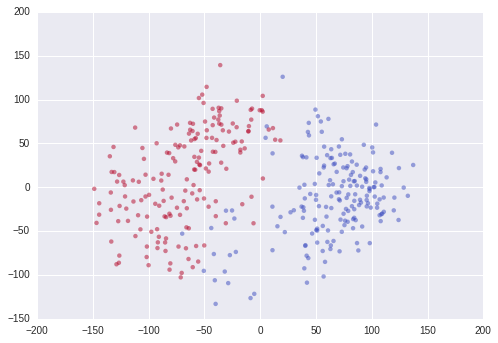

In [4]:
#Poly (The arguments we use here are from next part (b))
kpca = KernelPCA(kernel="poly",degree=2, gamma=0.05, coef0=121)
Xproj = kpca.fit_transform(X)
plt.scatter(Xproj[:, 0], Xproj[:, 1], c=y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('coolwarm', 2))
print ("fisher is :{}".format(fisher(Xproj,y)))

fisher is :2.25880741318


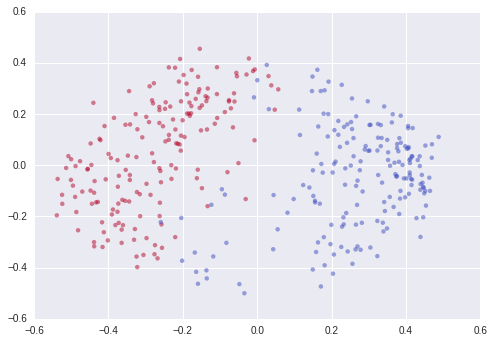

In [5]:
#rbf (The arguments we use here are from next question)
kpca = KernelPCA(kernel="rbf",gamma=0.0005)
Xproj = kpca.fit_transform(X)
plt.scatter(Xproj[:, 0], Xproj[:, 1], c=y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('coolwarm', 2))
print ("fisher is :{}".format(fisher(Xproj,y)))

#### Part (b) 

In [7]:
import math

#Please check the formula of polynomial kernel(you will see the meaning fo these three arguments). I choose degree from 2,3,4; gamma from exp(-20) to exp(-1); intercept from 
# 1 to 200. You might have different ranges but the optimal fisher should be around 2.2.
fi=[]
index=[]
for d in range(2,6):
    for c in range(1,200,20):
        for g in [math.exp(i) for i in np.linspace(-20,-1,20)]:
            kpca = KernelPCA(kernel="poly",degree=d, gamma=g, coef0=c)
            Xproj = kpca.fit_transform(X)
            temp=fisher(Xproj,y)
            fi.append(temp)
            index.append((d,c,g))
print("the biggest fisher we get is:{}, with parameters (degree,coef0,gamma)={}".
      format(max(fi),index[fi.index(max(fi))]))

the biggest fisher we get is:2.20562012447, with parameters (degree,coef0,gamma)=(2, 121, 0.049787068367863944)


In [8]:
# for rbf
# I choose the range for alpha from exp(-20) to exp(-1). The optimal fisher should be around 2.2. 
for g in [math.exp(i) for i in np.linspace(-20,-1,200)]:
    kpca = KernelPCA(kernel="rbf", gamma=g)
    Xproj = kpca.fit_transform(X)
    temp=fisher(Xproj,y)
    fi.append(temp)
    index.append(g)
print("the biggest fisher we get is:{}, with parameter gamma={}".
      format(max(fi),index[fi.index(max(fi))]))

the biggest fisher we get is:2.2588758653, with parameter gamma=0.000506523570923


In [ ]:
# This is an open question. For this question, if student gets a result around 2, we give credits no matter how they conducted the experiment.
# Graph should be plotted.

# Problem 2 (25%)

In this problem you'll use Sparse PCA on a (subset of a) publicly available community-level dataset with a large-ish number of real-valued features related to socioeconomic and crime statistics. See here for more details on the dataset:
<a href=http://archive.ics.uci.edu/ml/datasets/Communities+and+Crime>$\texttt{http://archive.ics.uci.edu/ml/datasets/Communities+and+Crime}$</a>

Use the SparsePCA module from sklearn to do Sparse PCA on the dataset. Notice that the alpha parameter controls the amount of sparsity. First choose a very large value of alpha. You should find that the identified principal components are all trivial (i.e. all identically zero). As you lower alpha, the leading principal component will at some point become non-trivial. 

__(a)__ What is the first non-trivial feature identified as important by Sparse PCA? (This may depend on some of the choices you make, e.g. which underlying sklearn algorithm you use)

__(b)__ As you continue to lower alpha you should eventually get to a point where the two leading (sparse) principal components are both non-trivial. Plot the data projected onto the two leading (sparse) principal components. Color each datapoint according to the column "ViolentCrimesPerPop_binary." Do the same thing for regular PCA. Which projection (PCA or Sparse PCA) leads to better separation (as judged visually) between low crime and high crime communities; or are they about the same? 

__(c)__ Compare the features identified by PCA and Sparse PCA as important. Is there strong overlap between the two sets of features?

In [9]:
data = pd.read_csv('https://serv.cusp.nyu.edu/classes/ML_2016_Spring/session3/HW/communities.csv')

#set up one feature to indicate whether a community has above or below average violent crime levels
data['ViolentCrimesPerPop_binary']=data['ViolentCrimesPerPop']>np.mean(data['ViolentCrimesPerPop'])                                                                    
data = data.astype(float)
values = data.values
print("features:\n",data.columns.values[0:25])
print("\nprediction target:",data.columns.values[25:27])

features:
 ['population' 'householdsize' 'racepctblack' 'racePctWhite' 'racePctAsian'
 'racePctHisp' 'agePct12t21' 'agePct12t29' 'agePct16t24' 'agePct65up'
 'numbUrban' 'pctUrban' 'medIncome' 'pctWWage' 'pctWFarmSelf' 'pctWInvInc'
 'pctWSocSec' 'pctWPubAsst' 'pctWRetire' 'medFamInc' 'perCapInc'
 'whitePerCap' 'blackPerCap' 'indianPerCap' 'AsianPerCap']

prediction target: ['ViolentCrimesPerPop' 'ViolentCrimesPerPop_binary']


### Solution

#### (a)

In [10]:
#find the first non-trivial feature: 
# My way to find the first non-trivial feature is set a very big alpha in the beginning, and then, decrease it until 
#we have one non-zero feature, we stop and report it. 

for i in range(40,1,-1):
    spca = SparsePCA(n_components=1,alpha=i,verbose=False,method='lars')
    X_proj = spca.fit_transform(values[:,0:25])
    if max(abs(spca.components_[0,:]))>0:
        print("first non-zero feature:\n",data.columns[0:25][spca.components_[0,:]!=0.0])
        print("the first non-trivial feature comes out when we set alpha equal to {}.".format(i))
        break

first non-zero feature:
 Index([u'racePctWhite'], dtype='object')
the first non-trivial feature comes out when we set alpha equal to 33.


#### (b)

we do not see big difference from graph!~


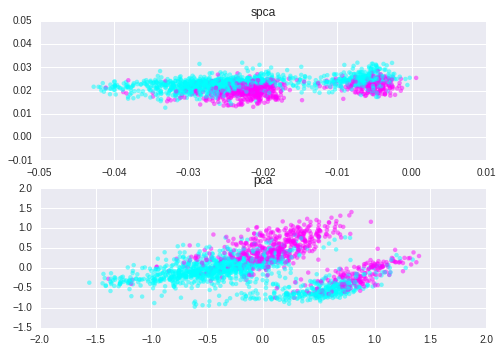

In [14]:
plt.figure(1)

spca = SparsePCA(n_components=2,alpha=8,verbose=False,method='lars')
X_proj = spca.fit_transform(values[:,0:25])
plt.subplot(211)
plt.scatter(X_proj[:, 0], X_proj[:, 1], c=values[:,26], edgecolor='none', alpha=0.5,
            cmap=plt.cm.cool)
plt.title('spca')


pca = PCA(n_components=2)
X_proj = pca.fit_transform(values[:,0:25])
plt.subplot(212)
plt.scatter(X_proj[:, 0], X_proj[:, 1], c=values[:,26], edgecolor='none', alpha=0.5,
            cmap=plt.cm.cool)
plt.title('pca')

print("we do not see big difference from graph!~")

#### (c)

In [11]:
# Let's compare the features by sparse PCA and PCA. (This is an open question.)

# fistly we know sparsePCA select features for us. so we must decide which alpha (equivalent to the number of features)
# we want to use. 
# for example, I choose alpha = 18, which will give me 9 non-trivial features. So, for different alphas, the answer will be different.
a=18 

spca = SparsePCA(n_components=1,alpha=a,verbose=False,method='lars')
X_proj = spca.fit_transform(values[:,0:25])
selector0=spca.components_[0,:]!=0.0 #Get the non-trivial ones
print("\nfeatures in leading principal component:\n",data.columns[0:25][selector0]) # get the variable names for these non-trivial features.

# Then we have a look the PCA.
#attribute "pca.components_" represents principal axes in feature space, representing the directions of
#maximum variance in data. Here we only look at the leading princial component, and of course, we
#can also compare the second principle component.
# I pick up the first eight(the number of non-trivial features from sparse PCA) features with biggest
# absolute explained variances.

pca = PCA(n_components=1)
X_proj = pca.fit_transform(values[:,0:25])
bigvariance=abs(pca.components_)>=np.sort(abs(pca.components_)[0])[-selector0.sum()]
print("\nfeatures in leading principal component:\n",data.columns[0:25][bigvariance[0]])


features in leading principal component:
 Index([u'householdsize', u'racePctWhite', u'agePct12t29', u'agePct65up',
       u'pctUrban', u'pctWWage', u'pctWInvInc', u'pctWSocSec', u'pctWRetire'],
      dtype='object')

features in leading principal component:
 Index([u'pctUrban', u'medIncome', u'pctWWage', u'pctWInvInc', u'pctWPubAsst',
       u'medFamInc', u'perCapInc', u'whitePerCap', u'blackPerCap'],
      dtype='object')


In [ ]:
#We do see some overlapped features but not much.

# Problem 3 (10%)
Suppose I have a $D-$dimensional dataset that I want to dimensionally reduce to $d<D$ dimensions using PCA.

__(a)__ Will the result be any different if I first rotate the data (i.e. with an arbitrary orthogonal or rotation matrix)? Why or why not?

__(b)__ Will the result be any different if I first apply an arbitrary linear transformation to the data? Why or why not?

__(c)__ Will the result be any different if I first offset the data by some fixed vector (i.e. translate the data by some fixed amount)? Why or why not?

# solution 

__(a)__ No; rotations won't change the eigenvalues of the data covariance matrix (although the eigenvectors will be rotated).

__(b)__ Yes; for example, arbitrary scaling of the data will scale eigenvalues of the data covariance matrix by arbitrary amounts (and thus change e.g. the leading principal component).

__(c)__ No; the (co)variance is invariant under translations (it's defined after subtracting off the mean)

# Problem 4 (10%)
Suppose we are given a large dataset distributed according to a $D$-dimensional normal distribution with zero mean and diagonal covariance matrix ($\Sigma = \sigma^2 \mathbb{1_{\rm{D}}}$ with $\sigma \in \mathbb{R}$, $\sigma>0$). Suppose we use PCA on the dataset to do dimensional reduction down to $d<D$ dimensions. 

__(a)__ What approximate fraction of the variance do you expect to be preserved by the mapping induced by PCA ($\mathbb{R}^D \to \mathbb{R}^d$)?

__(b)__ Does this fraction depend on the specific value of $\sigma$? If so how?

# solution 

__(a)__ $\frac{d}{D}<1$. This is because the eigenvalues of the data covariance matrix will all be about $\sigma^2$. Every direction in the $D$-dimensional space exhibits a similar amount of variance (only differing by noise). So every dimension we lop off results in a similar amount of variance loss. So for example if we lose half the dimensions in the dimensionality reduction we expect to lose half the variance.

__(b)__ No it does not. The data covariance matrix is approximately diagonal. Every direction is an eigenvector. The _magnitude_ of the eigenvalues changes as we change $\sigma$ but no matter what $\sigma$ is the argument in part __(a)__ still holds. 

# Problem 5 (10%)
Suppose that we a given a very high-dimensional dataset. Suppose furthermore that any given datapoint $\bf x_i$ is very sparse, i.e. most of the features are zero. Suppose further that the $\{ \bf x_i \}$ are all fixed to have unit length. Do you expect PCA to be of much use for dimensional reduction in this scenario? Why or why not? _Hint_: you might consider creating fake data and running PCA on it.

# solution  #1 (more theoretical)

Since the $\bf x_i$ are sparse for most pairs $i \ne j$ we have that  $\bf x_i$ and  $\bf x_j$ are orthogonal, i.e.  $\bf x_i \cdot x_j =0$. But this means that the $\bf x_i$ are typically equidistant from one another since  

$$\begin{equation}
|| \bf x_i - x_j ||^2 = || \bf x_i ||^2 + || \bf x_j ||^2 - 2 x_i \cdot x_j =  || \bf x_i ||^2 + || \bf x_j ||^2 = 2
\end{equation}$$

But PCA is built-up entirely around examining such squared distances between data points. Hence there is little or no structure that PCA is going to be able to uncover. Consequently we do not expect PCA to be of much use.

# solution #2 (more empirical)

Let's create some fake data as specified by the problem and run PCA on it.

mean pairwise distance in fake dataset: 1.41242136147
root variance in pairwise distances: 0.0714228748036


(0, 0.02)

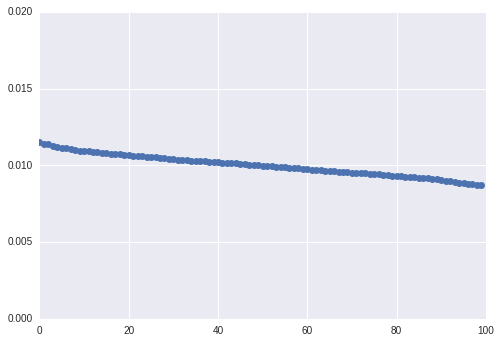

In [15]:
#This is again an open question. But we make sure any given example should satisfy:
#(a) the data is sparse(lots of zeros).
#(b) they should fix the length to one for every variable as required.
#(c) they should show why PCA does not work. (The reason is the eigenvalues' graph is flat as in my graph, and we do not
#know how to get rid of some of them)


def gen_fake_data(n_dim, n_sparseness, n_datapoints):
    X=[] ## the actual data
    dijs=[] ## store the pairwise distances between pairs of points
    signs = np.random.multinomial(n=1,pvals=[0.5,0.5],size=(n_datapoints,n_dim))
    for i in range(n_datapoints):
        x=[0]*n_dim
        coords = np.random.multinomial(n=n_sparseness,pvals=[1.0/n_dim]*n_dim)
        for dim in range(n_dim):
            if coords[dim]!=0:
                sign = (-1)**signs[i,dim,0]
                x[dim] += sign*coords[dim]
        x = np.array(x)
        x = x*(1/np.linalg.norm(x))
        X.append(x)
        
    for i in range(int(n_datapoints/20)):
        for j in range(i):
            dij = np.dot(X[i]-X[j],X[i]-X[j])
            dijs.append(np.sqrt(dij))
      
    print("mean pairwise distance in fake dataset:", np.mean(dijs))
    print("root variance in pairwise distances:", np.sqrt(np.var(dijs)))
    return np.array(X)

## generate data and run PCA on it and then plot eigenvalues
ndim=100 # notice that if you make this small (so that the data is not sparse)
         # you will find an eigenvalue spectrum that is less flat
X = gen_fake_data(ndim, 5, 20000)
pca = PCA(ndim)
Xproj = pca.fit_transform(X)
eigenvalues = pca.explained_variance_
plt.plot(np.arange(ndim), eigenvalues, 'o');
plt.ylim(0,0.02);
#print('principal',pca.components_[0,:])

# Problem 6 (10%)
Consider the four datasets plotted below (A, B, C, D) where each datapoint has an x-coordinate, a y-coordinate, and a binary indicator $z$ (0 or 1). Imagine doing PCA on these four datasets. After doing dimensional reduction down from 2 dimensions to 1, which dataset will exhibit the best separation between $z=0$ and $z=1$? You should be able to answer this question without any kind of calculations, but if you prefer, do the PCA explicitly and then give a well-reasoned argument that explains what you found.

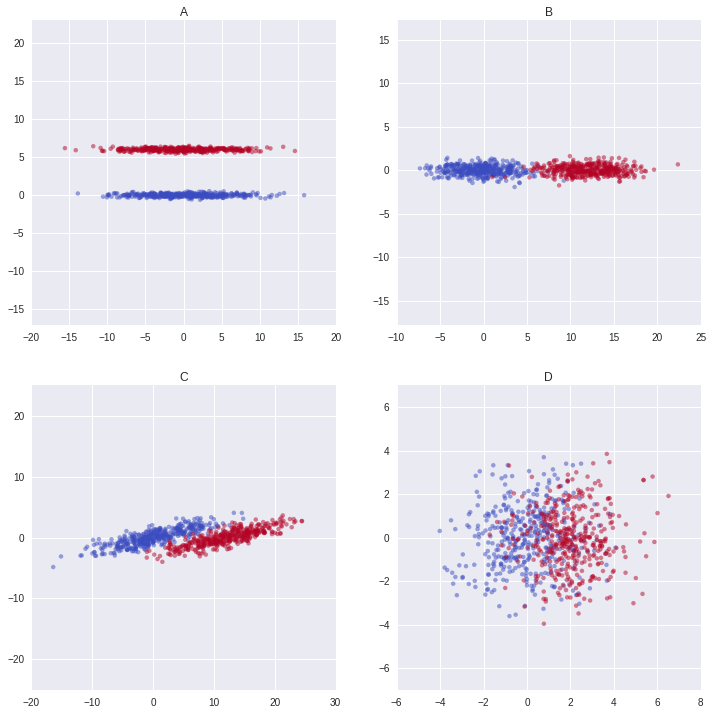

In [22]:
def get_dataset(a,b,c,d,x,y):
  XY1 = np.dot(np.array([[a,b],[c,d]]), np.random.normal(size=(2, 400))).T
  Z1 = np.ones(400)*0
  XY2 = [x,y]+np.dot(np.array([[a,b],[c,d]]), np.random.normal(size=(2, 400))).T
  Z2 = np.ones(400)*1
  XY=np.concatenate([XY1,XY2])  
  Z=np.concatenate([Z1,Z2])  
  return [XY,Z]

fig, ((axA, axB), (axC, axD)) = plt.subplots(nrows=2, ncols=2,figsize=(12,12))

[XY_A, Z_A] = get_dataset(5,0,0,.2,0,6)
[XY_B, Z_B] = get_dataset(2,2,.4,-.4,12,0)
[XY_C, Z_C] = get_dataset(5,1,1,1,12,0)
[XY_D, Z_D] = get_dataset(1,1,-1,1,2,0)

axA.scatter(XY_A[:, 0], XY_A[:, 1], c=Z_A, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('coolwarm', 2));
axA.set_title('A')
axB.scatter(XY_B[:, 0], XY_B[:, 1], c=Z_B, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('coolwarm', 2));
axB.set_title('B')
axC.scatter(XY_C[:, 0], XY_C[:, 1], c=Z_C, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('coolwarm', 2));
axC.set_title('C')
axD.scatter(XY_D[:, 0], XY_D[:, 1], c=Z_D, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('coolwarm', 2));
axD.set_title('D');
axA.axis('equal'); axB.axis('equal'); axC.axis('equal'); axD.axis('equal');

### Solution

dataset __B__.

(1) First step, we could see the highest variance covariance direction for data sets A and B and C. For example, for A and B it is x axis. For C, it is close to x axis. Obviousely, for B, if we map the data set on the x axis, we can distinguish almost all the blue points from red ones compared with A and C. 

(2) For D, we cannot see the direction of principle component(that line you want to map on) with biggest eigenvalues, but you can see these points cannot be divided seperately in any direction. So, it is obviously not the answer. 

# Extra credit problem  (25%)
Create an artificial dataset in two dimensions where each datapoint, in addition to having xy-coordinates, also has a binary indicator $z$, with $z=0$ or $z=1$. Consider doing Kernel PCA on the real coordinates ($D=2$ & $d=2$) and observing how well the Kernel PCA helps separate the datapoints with respect to the binary indicator $z$. The dataset you create should have the following properties:

- i) it _cannot_ be well separated using Kernel PCA with a low-dimensional polynomial kernel
- ii) it _can_ be well separated using Kernel PCA with a rbf kernel

Explain the properties of your dataset that make it satisfy i) and ii) and explicitly plot the results of using polynomial and rbf kernels on the dataset you've created so as to demonstrate i) and ii).

In [ ]:
# this is an open question.
#Student who can think out any date sets to satisfy i) and ii) would be given credits. 

### solution

In [19]:
from sklearn.datasets import make_circles
np.random.seed(0)
X, y = make_circles(n_samples=400, factor=.3, noise=.05)

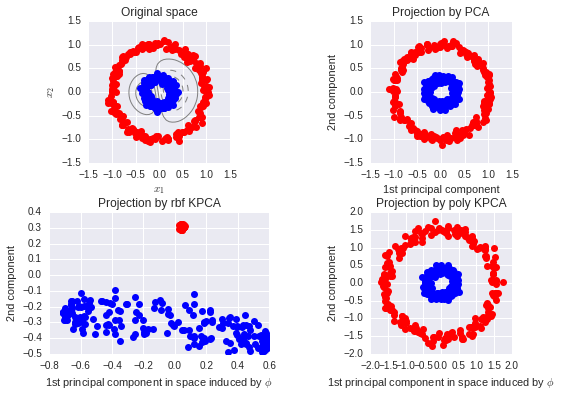

In [23]:
kpca = KernelPCA(kernel="rbf", fit_inverse_transform=True, gamma=10)
pca = PCA(n_components=2)

X_kpca = kpca.fit_transform(X)
X_back = kpca.inverse_transform(X_kpca)
kpca2 = KernelPCA(kernel="poly", degree=4)#, gamma=1, coef0=1)
X_kpca2 = kpca2.fit_transform(X)
X_pca = pca.fit_transform(X)

# Plot results

plt.figure()
plt.subplot(2, 2, 1, aspect='equal')
plt.title("Original space")
reds = y == 0
blues = y == 1

plt.plot(X[reds, 0], X[reds, 1], "ro")
plt.plot(X[blues, 0], X[blues, 1], "bo")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

X1, X2 = np.meshgrid(np.linspace(-1.5, 1.5, 50), np.linspace(-1.5, 1.5, 50))
X_grid = np.array([np.ravel(X1), np.ravel(X2)]).T
# projection on the first principal component (in the phi space)
Z_grid = kpca.transform(X_grid)[:, 0].reshape(X1.shape)
plt.contour(X1, X2, Z_grid, colors='grey', linewidths=1, origin='lower')

plt.subplot(2, 2, 2, aspect='equal')
plt.plot(X_pca[reds, 0], X_pca[reds, 1], "ro")
plt.plot(X_pca[blues, 0], X_pca[blues, 1], "bo")
plt.title("Projection by PCA")
plt.xlabel("1st principal component")
plt.ylabel("2nd component")

plt.subplot(2, 2, 3, aspect='equal')
plt.plot(X_kpca[reds, 0], X_kpca[reds, 1], "ro")
plt.plot(X_kpca[blues, 0], X_kpca[blues, 1], "bo")
plt.title("Projection by rbf KPCA")
plt.xlabel("1st principal component in space induced by $\phi$")
plt.ylabel("2nd component")

plt.subplot(2, 2, 4, aspect='equal')
plt.plot(X_kpca2[reds, 0], X_kpca2[reds, 1], "ro")
plt.plot(X_kpca2[blues, 0], X_kpca2[blues, 1], "bo")
plt.title("Projection by poly KPCA")
plt.xlabel("1st principal component in space induced by $\phi$")
plt.ylabel("2nd component")

plt.subplots_adjust(0.02, 0.10, 0.98, 0.94, 0.04, 0.35)

plt.show()